# Extract various statistics from the DB

In [1]:
import sqlite3 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
import itertools as it
import os
import pprint

from tqdm import tqdm

from matchms import Spectrum

from ssvm.data_structures import CandSQLiteDB_Massbank
from ssvm.evaluation_tools import get_topk_performance_csifingerid

In [2]:
mb_db_fn = "/home/bach/Documents/doctoral/projects/lcms2struct_experiments/data/massbank.sqlite"

## Baseline metabolite identification performance of the MS$^2$ scorers 

- CSI:FingerID (version 4)
- MetFrag (version 2.4.5)
- CFM-ID (version 4.0.7)

In [3]:
ms2scorers = [
    "metfrag__norm", "sirius__norm", "cfmid4__norm", "random"
]
molecule_identifier = "inchikey1"

In [4]:
conn = sqlite3.connect(mb_db_fn)
df = pd.read_sql(
    " \
    SELECT lds.dataset, split_id, lds.accession, %s AS molecule FROM lcms_data_splits lds \
         JOIN scored_spectra_meta ssm ON ssm.accession = lds.accession \
         JOIN molecules m ON ssm.molecule = m.cid \
    " % molecule_identifier, 
    conn
)
conn.close()

In [5]:
candidates = CandSQLiteDB_Massbank(mb_db_fn, molecule_identifier=molecule_identifier)

topk = []

for ((ds, split_id), info) in tqdm(df.groupby(["dataset", "split_id"])):    
    ms2_scores = {ms2scorer: {} for ms2scorer in ms2scorers}
    
    # Load the MS2-scores for each spectrum in the split
    for (idx, row) in info.iterrows():
        spec = Spectrum(
            np.array([]),  # empty spectrum
            np.array([]), 
            {
                "spectrum_id": row["accession"],
                "molecule_identifier": row["molecule"]
            }
        )
        
        # Index of correct structure in the label-space
        lab_space = candidates.get_labelspace(spec)
        idx_gt_mol = lab_space.index(spec.get("molecule_identifier")) 
        
        # Get the MS2-scores for each MS2-scorer, e.g. MetFrag.
        for ms2scorer in ms2scorers:
            if ms2scorer == "random":
                _score = np.random.rand(len(lab_space))
            else:
                _score = candidates.get_ms_scores(spec, ms2scorer, return_as_ndarray=True)
                
            ms2_scores[ms2scorer][idx] = {
                "score": _score,
                "index_of_correct_structure": idx_gt_mol,
                "n_cand": len(lab_space)
            }
            
    #  Computed the top-k accuracy
    for ms2scorer in ms2scorers:
        _acc = get_topk_performance_csifingerid(ms2_scores[ms2scorer])[1][:50]
        _topk = pd.DataFrame({
            "topk_acc": _acc,
            "k": (np.arange(len(_acc)) + 1),
            "dataset": ds,
            "split_id": split_id,
            "ms2scorer": ms2scorer
        })
        
        topk.append(_topk)
        
topk = pd.concat(topk, ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [18:27<00:00,  3.08s/it]


k,1,5,10,20
ms2scorer,,,,
CFM-ID,5.6,23.7,33.3,44.9
MetFrag,6.6,25.7,36.5,46.9
SIRIUS,36.3,62.9,71.3,77.7
random,2.0,7.7,12.7,19.2


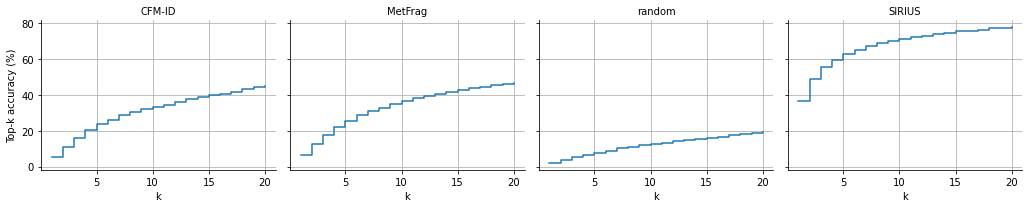

In [6]:
_res = topk[topk["dataset"] != "AU_001"]
_res = topk.groupby(["dataset", "k", "ms2scorer"]).mean().groupby(["k", "ms2scorer"]).mean().reset_index()
# _res = topk.groupby(["k", "ms2scorer"]).mean().reset_index()

for s, l in [("metfrag__norm", "MetFrag"), ("sirius__norm", "SIRIUS"), ("cfmid4__norm", "CFM-ID")]:
    _res.loc[_res["ms2scorer"] == s, "ms2scorer"] = l
    
# Step plots
#g = sns.FacetGrid(
#    data=_res[(_res["k"] <= 20) & (~ _res["ms2scorer"].isin(["random"]))], col="ms2scorer", aspect=1.2
#)
g = sns.FacetGrid(
    data=_res[_res["k"] <= 20], col="ms2scorer", aspect=1.2
)
g.map(sns.lineplot, "k", "topk_acc", drawstyle="steps-post")
g.set_titles("{col_name}")
_ = [g.axes[0, c].grid() for c in range(g.axes.shape[1])]
g.set_ylabels("Top-k accuracy (%)")
g.tight_layout()

for ext in ["pdf", "svg"]:
    plt.savefig(os.path.join(".", os.extsep.join(["base_ms2_performance__molid=%s" % molecule_identifier, ext])))

# Table
_res[(_res["k"].isin([1, 5, 10, 20]))] \
    .pivot(index=["ms2scorer"], columns=["k"], values="topk_acc") \
    .round(1)

## Ties in the MS2 Scoring

For the MS2 scores in the candidate sets, we have observed that many candidates can have the same score. This is especially the case when using MetFrag as the MS2 scoring method. Depending the MS2 scorer, i.e. MetFrag, SIRIUS or CFM-ID, the underlying reason for ties in the candidate scoring differ. For example, MetFrag seems to produce the same fragments for different molecualar strcutures which leads to ties in the scoring. On the otherhand, for SIRIUS if two candidate have the same molecular fingerprint, they will receive the same score. 

Here, we analyse statistics about the number of unique MS2 scores in relation to the number of candidates per spectrum and dataset. The idea is, to see whether the score ties effect the performance gain we can reach using retention order information.

In [40]:
ms2scorers = ["metfrag__norm", "sirius__norm", "cfmid4__norm"]

conn = sqlite3.connect(mb_db_fn)
datasets = [row[0] for row in conn.execute("SELECT name FROM datasets")]

df2 = []

for ds in tqdm(datasets):
    # Get all spectrum ids belonging to the current dataset
    specs = [row[0] for row in conn.execute("SELECT accession FROM scored_spectra_meta WHERE dataset IS ?", (ds, ))]
    
    for ms2scorer, spec in it.product(ms2scorers, specs):
        n_unq_scores, n_cand = conn.execute(
            " \
            SELECT COUNT(DISTINCT score), COUNT(candidate) FROM spectra_candidate_scores \
               INNER JOIN molecules m ON m.cid = spectra_candidate_scores.candidate \
               WHERE dataset IS ? AND spectrum IS ? AND scoring_method IS ? \
            ", (ds, spec, ms2scorer)
        ).fetchone()
             
        df2.append([ds, ms2scorer, spec, n_unq_scores, n_cand])
        
conn.close()

df2 = pd.DataFrame(df2, columns=["dataset", "ms2scorer", "accession", "n_unq_scores", "n_cand"])

df2["perc_unq_scores"] = (df2["n_unq_scores"] / df2["n_cand"]) * 100

for s, l in [("metfrag__norm", "MetFrag"), ("sirius__norm", "SIRIUS"), ("cfmid4__norm", "CFM-ID (v4)")]:
    df2.loc[df2["ms2scorer"] == s, "ms2scorer"] = l

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [03:52<00:00,  7.26s/it]


In [1]:
# sns.catplot(data=df2[(df2["n_unq_scores"] == 1) & (df2["n_cand"] > 1)], x="ms2scorer", kind="count", col="dataset", col_wrap=4)

In [55]:
df2["accession"].nunique()

8181

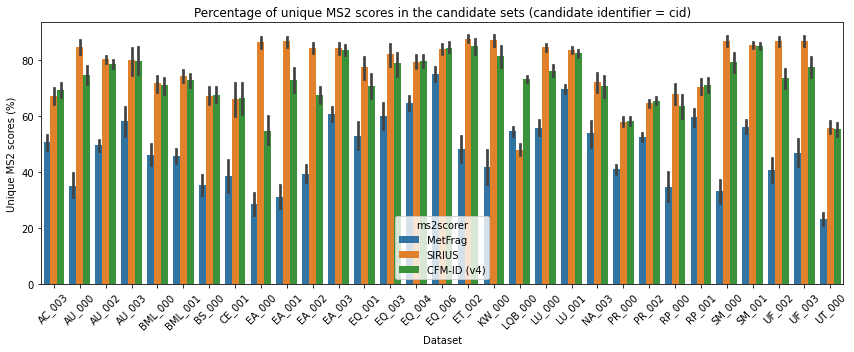

In [44]:
plt.figure(figsize=(12, 5))

ax = sns.barplot(
    data=df2[df2["dataset"] != "AU_001"],
    x="dataset", hue="ms2scorer", y="perc_unq_scores"
)
ax.set_xlabel("Dataset")
ax.set_ylabel("Unique MS2 scores (%)")
ax.set_title("Percentage of unique MS2 scores in the candidate sets (candidate identifier = cid)")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()

for ext in ["pdf", "svg"]:
    plt.savefig(os.path.join(".", os.extsep.join(["perc_of_uniq_candscores__molid=cid", ext])))

## Number of Examples per Dataset

In [3]:
conn = sqlite3.connect(mb_db_fn)
df3 = pd.read_sql(
    " \
    SELECT \
        scored_spectra_meta.dataset, \
        COUNT(inchikey) AS n_measurements, \
        COUNT(DISTINCT inchikey) AS n_unq_mol, \
        COUNT(DISTINCT inchikey2) - 1 AS n_unq_3D, \
        lds.n_samples \
        FROM scored_spectra_meta \
        \
        INNER JOIN datasets d ON d.name = scored_spectra_meta.dataset \
        INNER JOIN molecules m ON m.cid = scored_spectra_meta.molecule \
        INNER JOIN (SELECT dataset, COUNT(DISTINCT split_id) AS n_samples FROM lcms_data_splits GROUP BY dataset) lds ON lds.dataset = scored_spectra_meta.dataset \
        WHERE column_type IS 'RP' AND retention_time >= 3 * d.column_dead_time_min \
        GROUP BY scored_spectra_meta.dataset \
    ",
    conn
)
conn.close()

df3["p_3D_mol"] = np.round((df3["n_unq_3D"] / df3["n_unq_mol"]) * 100, 1)
df3["has_rt_model"] = df3["n_samples"] > 1

In [4]:
print(df3[["dataset", "n_measurements", "n_unq_mol", "n_unq_3D", "p_3D_mol", "n_samples", "has_rt_model"]].to_latex(index=False))

\begin{tabular}{lrrrrrl}
\toprule
dataset &  n\_measurements &  n\_unq\_mol &  n\_unq\_3D &  p\_3D\_mol &  n\_samples &  has\_rt\_model \\
\midrule
 AC\_003 &             179 &        136 &       109 &      80.1 &         15 &          True \\
 AU\_000 &             168 &        168 &        22 &      13.1 &         15 &          True \\
 AU\_002 &             746 &        704 &       146 &      20.7 &         14 &          True \\
 AU\_003 &              90 &         90 &        21 &      23.3 &         15 &          True \\
BML\_000 &             170 &        170 &        23 &      13.5 &         15 &          True \\
BML\_001 &             250 &        250 &        31 &      12.4 &         15 &          True \\
 BS\_000 &             216 &        216 &       121 &      56.0 &         15 &          True \\
 CE\_001 &              39 &         39 &        19 &      48.7 &          1 &         False \\
 EA\_000 &             141 &        141 &        19 &      13.5 &         15 &      

## Datasets and Classyfire (matplotlib)

In [8]:
conn = sqlite3.connect(mb_db_fn)

df4 = pd.DataFrame()

for lvl in ["superclass"]:
    df4 = pd.concat((df4, pd.read_sql(
        " \
        SELECT ssm.dataset, '%s' AS level, %s AS class_name, ROUND((CAST(COUNT() AS REAL) / n_mols_total) * 100, 1) AS p_mols, COUNT() AS n_mols FROM scored_spectra_meta ssm \
            INNER JOIN classyfire_classes cc ON ssm.molecule = cc.molecule \
            INNER JOIN datasets d ON d.name = ssm.dataset \
            INNER JOIN ( \
                SELECT dataset, COUNT(inchikey) AS n_mols_total FROM scored_spectra_meta \
                    INNER JOIN datasets d ON d.name = scored_spectra_meta.dataset \
                    INNER JOIN molecules m ON m.cid = scored_spectra_meta.molecule \
                    WHERE column_type IS 'RP' AND retention_time >= 3 * column_dead_time_min \
                    GROUP BY dataset \
                ) tmp ON tmp.dataset = ssm.dataset \
            WHERE column_type IS 'RP' AND retention_time >= 3 * column_dead_time_min \
            GROUP BY ssm.dataset, %s \
        " % (lvl, lvl, lvl),
        conn
    )))

conn.close()

df4.head()

,dataset,level,class_name,p_mols,n_mols
0,AC_003,superclass,Alkaloids and derivatives,10.1,18
1,AC_003,superclass,Benzenoids,5.6,10
2,AC_003,superclass,Hydrocarbon derivatives,0.6,1
3,AC_003,superclass,Lipids and lipid-like molecules,21.8,39
4,AC_003,superclass,Organic acids and derivatives,20.1,36


A ClassyFire class is only plotted if it covers at least 2.5% of the molecules in one dataset. All classes that individually are less than 2.5% are called "Others".

In [9]:
p_min = 2.5

df4.loc[df4["p_mols"] < p_min, "class_name"] = "Other"
df4 = df4.groupby(["dataset", "level", "class_name"]).sum().reset_index()
df4.head()

df4[df4["class_name"] == "Other"].sort_values(by="p_mols", ascending=False)

,dataset,level,class_name,p_mols,n_mols
98,EQ_004,superclass,Other,5.6,10
26,AU_003,superclass,Other,5.5,5
76,EA_003,superclass,Other,5.3,16
70,EA_002,superclass,Other,5.0,15
104,EQ_006,superclass,Other,4.7,10
180,SM_000,superclass,Other,4.3,7
33,BML_000,superclass,Other,4.2,7
126,LU_000,superclass,Other,4.0,14
141,NA_003,superclass,Other,4.0,4
187,SM_001,superclass,Other,3.7,13


Find unique colors for each class:

In [10]:
print("Number of unique ClassyFire classes (all datasets):", df4["class_name"].nunique())

colors = {}
for i, c in enumerate(df4["class_name"].unique().tolist()):
    if c != "Other":
        colors[c] = plt.get_cmap("tab20")(i)
    else:
        colors[c] = plt.get_cmap("Greys")(0.5)
        
# Print the colormap so that we can use the same colors for other parts of the manuscript
pprint.pprint(colors)

Number of unique ClassyFire classes (all datasets): 12
{'Alkaloids and derivatives': (0.12156862745098039,
                               0.4666666666666667,
                               0.7058823529411765,
                               1.0),
 'Benzenoids': (0.6823529411764706,
                0.7803921568627451,
                0.9098039215686274,
                1.0),
 'Lignans, neolignans and related compounds': (0.7686274509803922,
                                               0.611764705882353,
                                               0.5803921568627451,
                                               1.0),
 'Lipids and lipid-like molecules': (1.0,
                                     0.4980392156862745,
                                     0.054901960784313725,
                                     1.0),
 'Nucleosides, nucleotides, and analogues': (0.5490196078431373,
                                             0.33725490196078434,
                                       

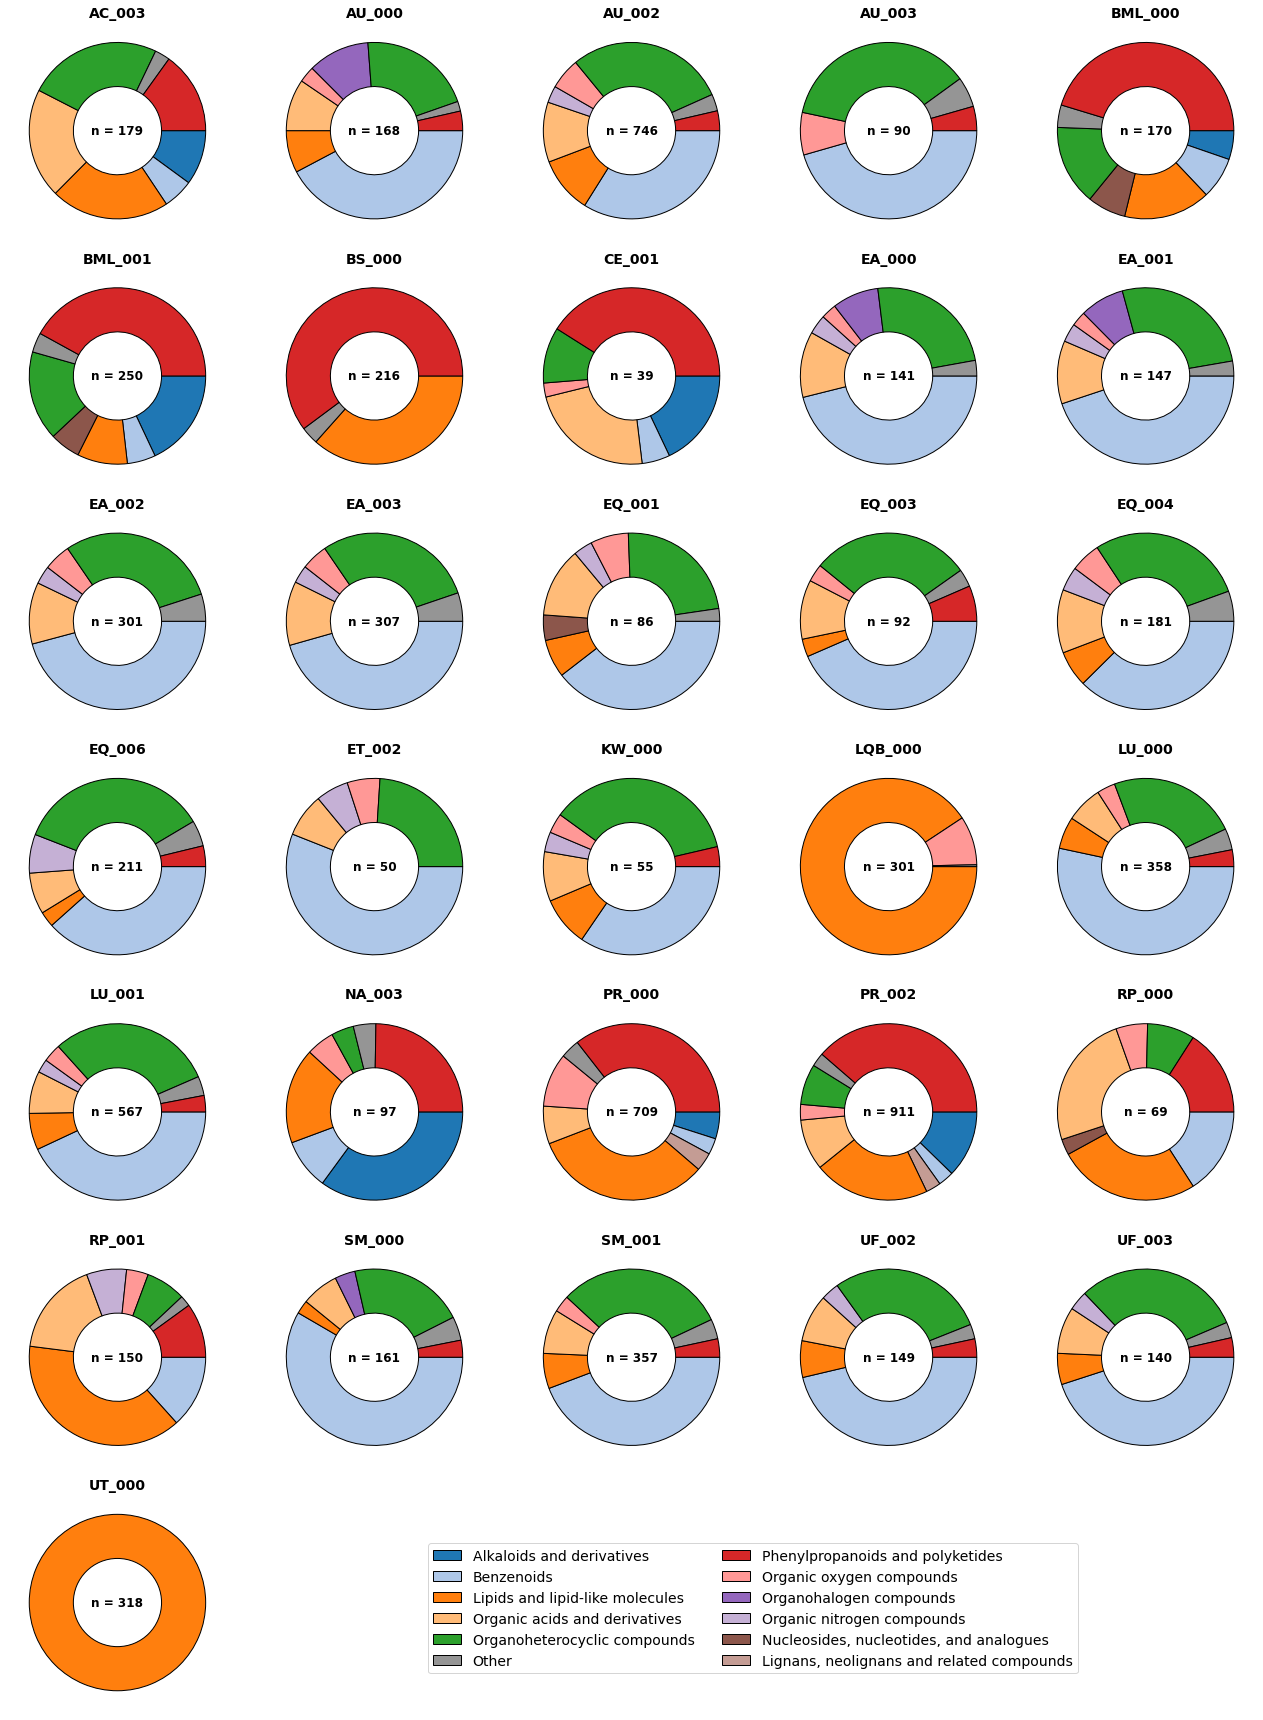

In [11]:
from matplotlib.patches import Wedge

fig, axrr = plt.subplots(7, 5, figsize=(18, 24))

for idx, ds in enumerate(df4["dataset"].unique().tolist()):
    r, c = np.unravel_index(idx, axrr.shape)
    
    _class_names = df4[df4["dataset"] == ds]["class_name"].tolist()
    
    _ = axrr[r, c].pie(
        df4[df4["dataset"] == ds]["n_mols"], 
        colors=[colors[c] for c in _class_names],
        radius=1,
        wedgeprops={"width": 0.5, "edgecolor": "black"},
        textprops={"color": "black"},
        counterclock=False,
        autopct=None,
        pctdistance=0.75,
        rotatelabels=True
    )
    
    axrr[r, c].set_title(ds, color="black", fontdict={"ha": "center", "va": "center", "weight": "bold", "size": 14})
    axrr[r, c].text(0, 0, "n = %d" % df4[df4["dataset"] == ds]["n_mols"].sum() , fontdict={"ha": "center", "va": "center", "weight": "bold", "size": 12})

for idx in range(df4["dataset"].nunique(), np.prod(axrr.shape)):
    r, c = np.unravel_index(idx, axrr.shape)
    fig.delaxes(axrr[r, c])

# Manually generate the labels for the legend
patches = [Wedge((0, 0), 1, 0, 0, 0.5, facecolor=colors[c], edgecolor="black") for c in df4["class_name"].unique().tolist()]
labels = df4["class_name"].unique().tolist()
fig.legend(patches, labels, loc='lower right', bbox_to_anchor=(0.35, 0.025, 0.5, 0.5), ncol=2, fontsize=14)

plt.tight_layout()

for ext in ["pdf", "svg"]:
    plt.savefig(os.path.join(".", os.extsep.join(["classyfire_classes_per_dataset", ext])))

### Classes with stereo

In [12]:
conn = sqlite3.connect(mb_db_fn)

df5 = pd.DataFrame()

for lvl in ["class"]:
    df5 = pd.concat((df5, pd.read_sql(
        " \
        SELECT ssm.dataset, '%s' AS level, %s AS class_name, ROUND((CAST(COUNT() AS REAL) / n_mols_total) * 100, 1) AS p_mols, COUNT() AS n_mols FROM scored_spectra_meta ssm \
            INNER JOIN classyfire_classes cc ON ssm.molecule = cc.molecule \
            INNER JOIN molecules mm ON ssm.molecule = mm.cid \
            INNER JOIN datasets d ON d.name = ssm.dataset \
            INNER JOIN ( \
                SELECT dataset, COUNT(inchikey) AS n_mols_total FROM scored_spectra_meta \
                    INNER JOIN datasets d ON d.name = scored_spectra_meta.dataset \
                    INNER JOIN molecules m ON m.cid = scored_spectra_meta.molecule \
                    WHERE column_type IS 'RP' AND retention_time >= 3 * column_dead_time_min AND inchikey2 is not 'UHFFFAOYSA' \
                    GROUP BY dataset \
                ) tmp ON tmp.dataset = ssm.dataset \
            WHERE column_type IS 'RP' AND retention_time >= 3 * column_dead_time_min AND mm.inchikey2 is not 'UHFFFAOYSA' \
            GROUP BY ssm.dataset, %s \
        " % (lvl, lvl, lvl),
        conn
    )))

conn.close()

df5 = df5.groupby(["level", "class_name"]).sum().reset_index()
df5[df5["n_mols"] >= 25].sort_values(by="n_mols", ascending=False)

,level,class_name,p_mols,n_mols
48,class,Glycerophospholipids,180.1,487
107,class,Steroids and steroid derivatives,427.7,199
23,class,Carboxylic acids and derivatives,436.3,166
42,class,Flavonoids,191.6,163
93,class,Prenol lipids,152.6,144
10,class,Benzene and substituted derivatives,299.2,107
81,class,Organooxygen compounds,169.1,101
105,class,Sphingolipids,21.5,60
41,class,Fatty Acyls,85.3,41
27,class,Cinnamic acids and derivatives,48.0,32


## Number of examples per dataset (v2)

In [7]:
conn = sqlite3.connect(mb_db_fn)

# FULLDATA setup (training and evaluation)
df_numex_fulldata = pd.read_sql(
    "select dataset, count() as n_tuples from scored_spectra_meta"
    "   inner join datasets d on d.name = scored_spectra_meta.dataset"
    "   where column_type == 'RP' and retention_time >= 3 * d.column_dead_time_min"
    "   group by dataset",
    conn,
    index_col="dataset"
)

# ONLYSTEREO setup (training)
df_numex_onlystereo_training = pd.read_sql(
    "select dataset, count() as n_tuples from ("
    "   select accession, dataset from scored_spectra_meta"
    "      inner join molecules m on m.cid = scored_spectra_meta.molecule"
    "      inner join datasets d on scored_spectra_meta.dataset = d.name"
    "   where retention_time >= 3 * column_dead_time_min"
    "     and inchikey2 != 'UHFFFAOYSA'"
    "     and column_type == 'RP'"
    " "
    "   union"
    " "
    "   select accession, dataset from ("
    "      select accession, dataset, count(distinct m2.inchikey) as cnt from ("
    "         select accession, dataset, inchikey1, inchikey2 from scored_spectra_meta"
    "            inner join molecules m on m.cid = scored_spectra_meta.molecule"
    "            inner join datasets d on scored_spectra_meta.dataset = d.name"
    "            where retention_time >= 3 * column_dead_time_min"
    "              and column_type == 'RP'"
    "              and inchikey2 == 'UHFFFAOYSA'"
    "      ) t1"
    "   inner join molecules m2 on m2.inchikey1 = t1.inchikey1"
    "   group by accession, m2.inchikey1"
    "   ) t2"
    "   where t2.cnt == 1"
    ")"
    "   group by dataset", 
    conn,
    index_col="dataset"
)


# ONLYSTEREO setup (evaluation)
df_numex_onlystereo_evaluation = pd.read_sql(
    "select dataset, count() as n_tuples from scored_spectra_meta"
    "      inner join molecules m on m.cid = scored_spectra_meta.molecule"
    "      inner join datasets d on scored_spectra_meta.dataset = d.name"
    "   where retention_time >= 3 * column_dead_time_min"
    "     and inchikey2 != 'UHFFFAOYSA'"
    "     and column_type == 'RP'"
    "   group by dataset", 
    conn,
    index_col="dataset"
)

conn.close()

,dataset,n_tuples,n_tuples,n_tuples
0,AC_003,179,172,157
1,AU_000,168,146,23
2,AU_002,746,578,172
3,AU_003,90,77,21
4,BML_000,170,77,24
5,BML_001,250,125,33
6,BS_000,216,205,135
7,CE_001,39,30,19
8,EA_000,141,118,19
9,EA_001,147,126,19


## Number of (train, test)-splits per Dataset

In [54]:
conn = sqlite3.connect(mb_db_fn)
df = pd.read_sql(
    "select dataset, experiment, count(distinct split_id) as n_samples from lcms_data_splits"
    "   inner join datasets d on d.name = lcms_data_splits.dataset"
    "   where column_type == 'RP'"
    "   group by dataset, experiment"
    "   order by dataset",
    conn
)
conn.close()

tmp = df.pivot(index="dataset", columns="experiment", values="n_samples").fillna(0).astype(int)

df_numsp_fulldata = tmp.loc[:, ["default"]].rename({"default": "FULLDATA"}, axis=1)
df_numsp_onlystereo = tmp.loc[:, ["with_stereo"]].rename({"with_stereo": "ONLYSTEREO"}, axis=1)

tmp

experiment,default,with_stereo
dataset,,
AC_003,15,15
AU_000,15,0
AU_002,14,15
AU_003,15,0
BML_000,15,0
BML_001,15,1
BS_000,15,15
CE_001,1,0
EA_000,15,0


In [70]:
tmp = pd.concat(
    [df_numex_fulldata, df_numsp_fulldata, df_numex_onlystereo_training, df_numex_onlystereo_evaluation, df_numsp_onlystereo], axis=1, join="inner"
) \
    .reset_index()

tmp.columns = pd.MultiIndex.from_tuples([("", "Dataset"), ("FULLDATA", "#Tuples"), ("FULLDATA", "#Experiments"), ("ONLYSTEREO", "#Tuples (training)"), ("ONLYSTEREO", "#Tuples (evaluation)"), ("ONLYSTEREO", "#Experiments")])

print(pd.concat((tmp, pd.DataFrame(tmp.sum()).T), axis=0).to_latex(index=False, multicolumn_format="c"))

\begin{tabular}{llllll}
\toprule
                                                   & \multicolumn{2}{c}{FULLDATA} & \multicolumn{3}{c}{ONLYSTEREO} \\
                                           Dataset &  \#Tuples & \#Experiments & \#Tuples (training) & \#Tuples (evaluation) & \#Experiments \\
\midrule
                                            AC\_003 &      179 &           15 &                172 &                  157 &           15 \\
                                            AU\_000 &      168 &           15 &                146 &                   23 &            0 \\
                                            AU\_002 &      746 &           14 &                578 &                  172 &           15 \\
                                            AU\_003 &       90 &           15 &                 77 &                   21 &            0 \\
                                           BML\_000 &      170 &           15 &                 77 &                   24 &            0

In [5]:
tmp.sum()

experiment
dataset        AC_003AU_000AU_002AU_003BML_000BML_001BS_000CE...
default                                                      354
with_stereo                                                   94
dtype: object

In [6]:
print("== DEFAULT ==")
print("Number result rows (more than one sample):", sum(tmp["default"][(tmp["default"] > 1) & (tmp["dataset"] != "AU_001")]) * 50)
print("Number result rows (single sample only):", sum(tmp["default"][(tmp["default"] == 1) & (tmp["dataset"] != "AU_001")]) * 50)
print("Number result rows (all):", sum(tmp["default"][tmp["dataset"] != "AU_001"]) * 50)

print("== WITH_STEREO ==")
print("Number result rows (more than one sample):", sum(tmp["with_stereo"][(tmp["with_stereo"] > 1) & (tmp["with_stereo"] != "AU_001")]) * 50)
print("Number result rows (single sample only):", sum(tmp["with_stereo"][(tmp["with_stereo"] == 1) & (tmp["with_stereo"] != "AU_001")]) * 50)
print("Number result rows (all):", sum(tmp["with_stereo"][tmp["with_stereo"] != "AU_001"]) * 50)

== DEFAULT ==
Number result rows (more than one sample): 17500
Number result rows (single sample only): 200
Number result rows (all): 17700
== WITH_STEREO ==
Number result rows (more than one sample): 4250
Number result rows (single sample only): 450
Number result rows (all): 4700


## Number of Isomers per ground-truth candidate in the 'massbank__with_stereo' setting

In [3]:
conn = sqlite3.connect(mb_db_fn)
df = pd.read_sql(
    "select dataset, round(avg(isomer_count), 1) as avg_isomer_count, min(isomer_count) as min_isomer_count, max(isomer_count) as max_isomer_count,"
    "    group_concat(isomer_count) as isomer_counts"
    "    from ("
    "      select dataset, count(distinct m2.inchikey) as isomer_count"
    "          from ("
    "              select accession, dataset, inchikey, inchikey1, inchikey2, cid from scored_spectra_meta"
    "                  inner join molecules m on m.cid = scored_spectra_meta.molecule"
    "                  inner join datasets d on scored_spectra_meta.dataset = d.name"
    "                  where retention_time >= 3 * column_dead_time_min"
    "                    and column_type == 'RP'"
    "                    and inchikey2 != 'UHFFFAOYSA'"
    "              ) t1"
    "      inner join molecules m2 on m2.inchikey1 = t1.inchikey1"
    "      group by accession"
    "    ) t2"
    " group by t2.dataset",
    conn
)
df = df.assign(median_isomer_count=df["isomer_counts"].apply(lambda x: np.median(list(map(int, x.split(","))))))
df = df.drop("isomer_counts", axis=1)
conn.close()

df.sort_values(by="median_isomer_count", ascending=False)

,dataset,avg_isomer_count,min_isomer_count,max_isomer_count,median_isomer_count
28,UF_002,41.8,3,108,35.5
29,UF_003,37.3,3,108,33.0
3,AU_003,44.9,2,154,27.0
1,AU_000,27.0,3,66,27.0
2,AU_002,28.7,1,154,22.0
21,NA_003,27.3,1,145,20.0
23,PR_002,20.6,1,123,16.0
22,PR_000,22.5,1,72,15.0
12,EQ_001,21.5,3,116,15.0
14,EQ_004,24.3,3,116,14.0


## Meta-information for the MassBank groups

In [7]:
conn = sqlite3.connect(mb_db_fn)

tmp = pd.read_sql(
    "select name as 'MB-subset', contributor as 'Contributor', "
    "   column_name as 'Column Name', column_temperature as 'Column Temp.', flow_rate as 'Flow rate', flow_gradient as 'Flow gradient', solvent_A as 'Solvent A', solvent_B as 'Solvent B', "
    "   instrument as 'Instrument', instrument_type as 'Instrument type', ion_mode as 'Ionization mode', fragmentation_mode as 'Fragmentation mode',"
    "   column_dead_time_min as 'Estimated column dead time (min)'"
    "   from datasets "
    "   where column_type == 'RP'",
    conn
)

_tupl = [
    ("", tmp.columns[0]), ("", tmp.columns[1]),
    ("Liquid chromatography (LC)", tmp.columns[2]), ("Liquid chromatography (LC)", tmp.columns[3]), 
    ("Liquid chromatography (LC)", tmp.columns[4]), ("Liquid chromatography (LC)", tmp.columns[5]), 
    ("Liquid chromatography (LC)", tmp.columns[6]), ("Liquid chromatography (LC)", tmp.columns[7]),
    ("Mass spectrometry (MS)", tmp.columns[8]), ("Mass spectrometry (MS)", tmp.columns[9]), 
    ("Mass spectrometry (MS)", tmp.columns[10]), ("Mass spectrometry (MS)", tmp.columns[11]),
    ("", tmp.columns[12])
]

tmp.columns = pd.MultiIndex.from_tuples(_tupl)

conn.close()

# with pd.option_context('display.max_colwidth', -1):
#     print(tmp.to_latex(index=False, multicolumn_format="c"))
     
tmp.to_csv("massbank_groups__meta_data.tsv", index=False, sep="\t")